In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [ ]:
data = mat73.loadmat("/content/assignmentImageDenoising_microscopy.mat")
data


{'microscopyImageNoisyScale350sigma0point06': array([[[155.91058 , 163.4861  , 146.54857 ],
         [146.10088 , 102.68085 , 159.91495 ],
         [134.30069 , 165.3166  , 155.90617 ],
         ...,
         [112.30346 ,  73.691635, 157.2495  ],
         [141.15758 ,  95.308945, 172.60683 ],
         [229.66435 , 147.14001 , 171.46059 ]],
 
        [[126.9173  , 107.489365, 141.90878 ],
         [123.73052 , 135.85608 , 104.76373 ],
         [144.40294 , 139.41339 , 170.45766 ],
         ...,
         [ 88.20096 ,  69.40452 , 155.61375 ],
         [137.41803 ,  98.69285 , 168.19753 ],
         [194.87753 , 154.46803 , 202.49239 ]],
 
        [[160.96228 , 130.72406 , 144.30884 ],
         [137.38182 , 162.51607 , 145.58838 ],
         [176.20775 , 125.084045, 176.83658 ],
         ...,
         [ 75.6148  ,  84.731   , 120.34476 ],
         [114.3223  ,  84.859566, 179.43657 ],
         [165.27641 , 142.08649 , 181.76326 ]],
 
        ...,
 
        [[232.65244 , 188.42633 , 183.5132 

In [ ]:
noisy_img = data['microscopyImageNoisyScale350sigma0point06']
noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
clean_img = data['microscopyImageOrig']
clean_img = (clean_img-clean_img.min()) / (clean_img.max() - clean_img.min())

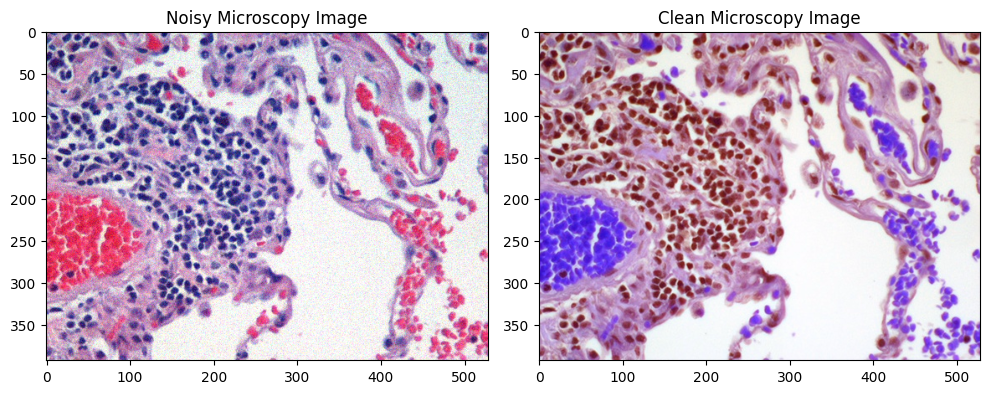

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.abs(noisy_img), cmap='jet')
axes[0].set_title("Noisy Microscopy Image")

axes[1].imshow(np.abs(clean_img), cmap='jet')
axes[1].set_title("Clean Microscopy Image")

plt.tight_layout()
plt.show()

In [ ]:
# Normalize to [0, 1]
clean_img = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min())
noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())


In [ ]:
clean_tensor = torch.tensor(clean_img).float().permute(2, 0, 1)  # HWC to CHW
noisy_tensor = torch.tensor(noisy_img).float().permute(2, 0, 1).requires_grad_(False)

In [ ]:
def denoise(noisy, prior_fn, λ, δ=0.1, iterations=500, lr=0.05):
    """Generic denoising function with MRF prior"""
    x = noisy.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([x], lr=lr)
    objectives = []

    for _ in range(iterations):
        optimizer.zero_grad()

        data_term = 0.5 * torch.sum((x - noisy) ** 2)

        prior_term = prior_fn(x, δ) if prior_fn.__name__ == 'huber_prior' else prior_fn(x)

        total_energy = data_term + λ * prior_term
        total_energy.backward()
        optimizer.step()

        with torch.no_grad():
            x.data = torch.clamp(x.data, 0, 1)
            objectives.append(total_energy.item())

    return x.detach().permute(1, 2, 0).numpy(), objectives  # Convert back to HWC

In [ ]:
def squared_l2_prior(x, δ=None):
    diff_h = x[..., 1:] - x[..., :-1]
    diff_v = x[..., 1:, :] - x[..., :-1, :]
    return 0.5 * (torch.sum(diff_h**2) + torch.sum(diff_v**2))

def l2_prior(x, δ=None):
    diff_h = x[..., 1:] - x[..., :-1]
    diff_v = x[..., 1:, :] - x[..., :-1, :]
    return torch.sum(torch.sqrt(torch.sum(diff_h**2, dim=0) + 1e-8)) + \
           torch.sum(torch.sqrt(torch.sum(diff_v**2, dim=0) + 1e-8))

def huber_prior(x, δ=0.1):
    def huber(x, δ):
        return torch.where(torch.abs(x) < δ, 0.5*x**2/δ, torch.abs(x) - 0.5*δ)

    diff_h = x[..., 1:] - x[..., :-1]
    diff_v = x[..., 1:, :] - x[..., :-1, :]
    return torch.sum(huber(diff_h, δ)) + torch.sum(huber(diff_v, δ))

In [ ]:
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))

In [ ]:
rrmse(clean_img, noisy_img)

0.19455159868091937

In [ ]:
params = {
    'A': {'λ': 0.2, 'prior': squared_l2_prior},
    'B': {'λ': 0.15, 'prior': l2_prior},
    'C': {'λ': 0.1, 'δ': 0.05, 'prior': huber_prior}
}

In [ ]:
results = {}
for case in ['A', 'B', 'C']:
    kwargs = {'δ': params[case]['δ']} if case == 'C' else {}
    denoised, objectives = denoise(
        noisy_tensor,
        params[case]['prior'],
        params[case]['λ'],
        **kwargs
    )
    rmse = rrmse(clean_img, denoised)
    results[case] = (denoised, objectives, rmse)

(-0.5, 527.5, 392.5, -0.5)

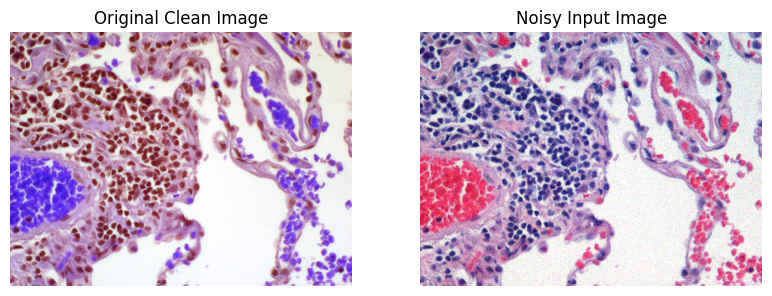

In [ ]:
plt.figure(figsize=(15, 10))

# Original images
plt.subplot(2, 3, 1)
plt.imshow(clean_img)
plt.title('Original Clean Image')
plt.axis('off')

# Noisy image
plt.subplot(2, 3, 2)
plt.imshow(noisy_img)
plt.title('Noisy Input Image')
plt.axis('off')

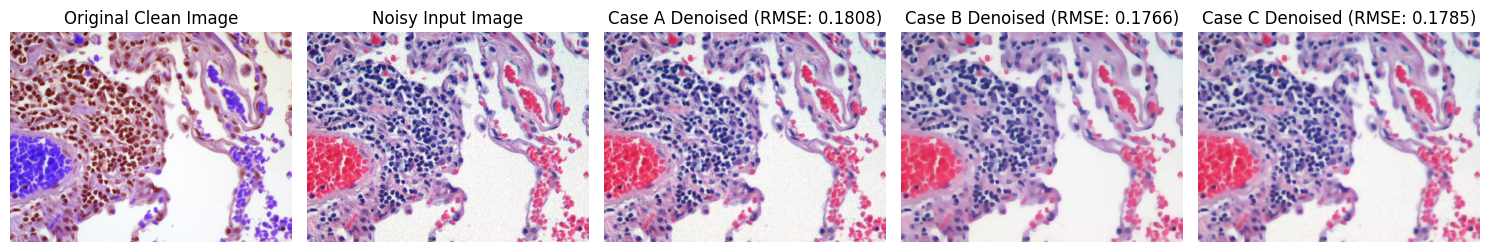

In [ ]:
titles = [
    'Original Clean Image',
    'Noisy Input Image',
    f'Case A Denoised (RMSE: {results["A"][2]:.4f})',
    f'Case B Denoised (RMSE: {results["B"][2]:.4f})',
    f'Case C Denoised (RMSE: {results["C"][2]:.4f})'
]

# List of images to display
images = [clean_img, noisy_img, results['A'][0], results['B'][0], results['C'][0]]

plt.figure(figsize=(15, 5))

for i, (img, title) in enumerate(zip(images, titles), 1):
    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

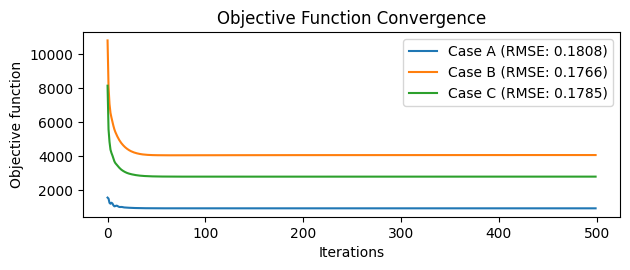

In [ ]:
# Objective functions
plt.subplot(2, 1, 2)
for case in ['A', 'B', 'C']:
    plt.plot(results[case][1], label=f'Case {case} (RMSE: {results[case][2]:.4f})')
plt.title('Objective Function Convergence')
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.legend()

plt.tight_layout()
plt.show()